In [1]:
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

es = Elasticsearch(['127.0.0.1'], port=9200, timeout=480)


In [2]:
successful_logon=es.search(index='winlogbeat-*', body = {
    'size': 500,
    'query': {
        'bool': {
           'must': [
                {"match" : {'source_name': "Microsoft-Windows-Security-Auditing" }},
                {"match": {'event_id': 4624}},
                {"match": {'event_data.LogonType': 3}}
           ],
            'must_not': [
                {"match" : {'event_data.IpAddress': "::1" }},
                {"match": {'event_data.TargetUserName': "ANONYMOUS LOGON"}}
            ],
            "filter": [
                {"range" : {"@timestamp" : {"gt": "now-7d", "lt" : "now"}}}
           ]    
        }
        
    }
})

sysmon_network=es.search(index='winlogbeat-*', body = {
    'size': 500,
    'query': {
        'bool': {
           'must': [
               {"match": {'source_name': 'Microsoft-Windows-Sysmon'}},
               {"match": {'event_id': 3}}
           ],
            "filter": [
                {"range" : {"@timestamp" : {"gt": "now-7d", "lt" : "now"}}}
           ]    
        }
        
    }
})

In [3]:
successful_logon

{u'_shards': {u'failed': 0, u'successful': 20, u'total': 20},
 u'hits': {u'hits': [{u'_id': u'AV2XExYFqwKBlIxA_NrX',
    u'_index': u'winlogbeat-2017.07.31',
    u'_score': 2.6710901,
    u'_source': {u'@timestamp': u'2017-07-31T05:15:38.640Z',
     u'@version': u'1',
     u'beat': {u'hostname': u'VA-WK-HR003',
      u'name': u'VA-WK-HR003',
      u'version': u'5.5.0'},
     u'computer_name': u'VA-WK-HR003.hf.com',
     u'event_data': {u'AuthenticationPackageName': u'Kerberos',
      u'IpAddress': u'172.18.39.100',
      u'IpPort': u'28386',
      u'KeyLength': u'0',
      u'LmPackageName': u'-',
      u'LogonGuid': u'{1F0E4375-7C62-9817-7FD5-796432AA8CEB}',
      u'LogonProcessName': u'Kerberos',
      u'LogonType': u'3',
      u'ProcessId': u'0x0',
      u'ProcessName': u'-',
      u'SubjectDomainName': u'-',
      u'SubjectLogonId': u'0x0',
      u'SubjectUserName': u'-',
      u'SubjectUserSid': u'S-1-0-0',
      u'TargetDomainName': u'HF',
      u'TargetLogonId': u'0x1f80d45',
   

In [4]:
sysmon_network

{u'_shards': {u'failed': 0, u'successful': 20, u'total': 20},
 u'hits': {u'hits': [{u'_id': u'AV2XEOvqqwKBlIxA_NCe',
    u'_index': u'winlogbeat-2017.07.31',
    u'_score': 1.5883751,
    u'_source': {u'@timestamp': u'2017-07-31T05:13:16.670Z',
     u'@version': u'1',
     u'beat': {u'hostname': u'VA-WK-HR001',
      u'name': u'VA-WK-HR001',
      u'version': u'5.2.1'},
     u'computer_name': u'VA-WK-HR001.hf.com',
     u'event_data': {u'DestinationHostname': u'VA-WK-ACCT001',
      u'DestinationIp': u'172.18.39.101',
      u'DestinationIsIpv6': u'false',
      u'DestinationPort': u'80',
      u'DestinationPortName': u'http',
      u'Image': u'C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe',
      u'Initiated': u'true',
      u'ProcessGuid': u'{ACECDF70-BC39-597E-0000-00101A4AA109}',
      u'ProcessId': u'1328',
      u'Protocol': u'tcp',
      u'SourceHostname': u'VA-WK-HR001.hf.com',
      u'SourceIp': u'172.18.39.100',
      u'SourceIsIpv6': u'false',
      u'SourceP

In [5]:
res1 = map(lambda x: x["_source"],successful_logon['hits']['hits'])

In [6]:
res2 = map(lambda x: x["_source"],sysmon_network['hits']['hits'])

In [7]:
sl_df=json_normalize(res1)
sl_df.head(50)

,@timestamp,@version,beat.hostname,beat.name,beat.version,computer_name,event_data.AuthenticationPackageName,event_data.ImpersonationLevel,event_data.IpAddress,event_data.IpPort,...,opcode,process_id,provider_guid,record_number,source_name,tags,task,thread_id,type,version
0,2017-07-31T05:15:38.640Z,1,VA-WK-HR003,VA-WK-HR003,5.5.0,VA-WK-HR003.hf.com,Kerberos,NaN,172.18.39.100,28386,...,Info,488,{54849625-5478-4994-A5BA-3E3B0328C30D},21998,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,3640,wineventlog,NaN
1,2017-07-31T05:19:24.107Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,Kerberos,NaN,172.18.39.107,50805,...,Info,488,{54849625-5478-4994-A5BA-3E3B0328C30D},24660,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,3804,wineventlog,NaN
2,2017-07-31T05:22:08.705Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1833,172.18.39.102,49359,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7711572,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,316,wineventlog,1.0
3,2017-07-31T05:22:07.608Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1833,172.18.39.102,49356,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7711565,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,316,wineventlog,1.0
4,2017-07-31T05:27:49.703Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1833,fe80::2036:13d7:5626:b29b,52343,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7713870,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,316,wineventlog,1.0
5,2017-07-31T05:32:04.244Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1840,172.18.39.107,50925,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7713914,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,12816,wineventlog,1.0
6,2017-07-31T05:32:11.718Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1833,fe80::2036:13d7:5626:b29b,52353,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7713929,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,316,wineventlog,1.0
7,2017-07-31T05:33:10.377Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1840,172.18.39.107,50935,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7713960,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,13084,wineventlog,1.0
8,2017-07-31T05:38:57.104Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1840,-,-,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7714013,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,12816,wineventlog,1.0
9,2017-07-31T05:39:39.226Z,1,HFDC01,HFDC01,5.5.0,HFDC01.hf.com,Kerberos,%%1840,fe80::2036:13d7:5626:b29b,52378,...,Info,484,{54849625-5478-4994-A5BA-3E3B0328C30D},7714021,Microsoft-Windows-Security-Auditing,[beats_input_codec_plain_applied],Logon,12816,wineventlog,1.0


In [8]:
sn_df=json_normalize(res2)
sn_df.head(50)

,@timestamp,@version,beat.hostname,beat.name,beat.version,computer_name,event_data.DestinationHostname,event_data.DestinationIp,event_data.DestinationIsIpv6,event_data.DestinationPort,...,source_name,tags,task,thread_id,type,user.domain,user.identifier,user.name,user.type,version
0,2017-07-31T05:13:16.670Z,1,VA-WK-HR001,VA-WK-HR001,5.2.1,VA-WK-HR001.hf.com,VA-WK-ACCT001,172.18.39.101,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2040,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
1,2017-07-31T05:14:08.216Z,1,VA-WK-HR001,VA-WK-HR001,5.2.1,VA-WK-HR001.hf.com,VA-WK-ACCT001,172.18.39.101,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2040,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
2,2017-07-31T05:13:44.686Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,VA-WK-ACCT002.hf.com,fe80:0:0:0:9cb:db2:c419:19f1,true,50965,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2764,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
3,2017-07-31T05:13:44.686Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,VA-WK-ACCT002.hf.com,fe80:0:0:0:9cb:db2:c419:19f1,true,61794,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2764,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
4,2017-07-31T05:14:42.934Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,HFDC01,172.18.39.2,false,389,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2764,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
5,2017-07-31T05:14:44.243Z,1,VA-WK-HR001,VA-WK-HR001,5.2.1,VA-WK-HR001.hf.com,VA-WK-ACCT001,172.18.39.101,false,80,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2040,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
6,2017-07-31T05:14:44.191Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,VA-WK-ACCT002.hf.com,fe80:0:0:0:9cb:db2:c419:19f1,true,49271,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2764,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
7,2017-07-31T05:14:44.691Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,VA-WK-ACCT002.hf.com,fe80:0:0:0:9cb:db2:c419:19f1,true,63229,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2764,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
8,2017-07-31T05:14:46.332Z,1,VA-WK-ACCT002,VA-WK-ACCT002,5.5.0,VA-WK-ACCT002.hf.com,NaN,255.255.255.255,false,67,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2764,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5
9,2017-07-31T05:14:46.243Z,1,VA-WK-HR001,VA-WK-HR001,5.2.1,VA-WK-HR001.hf.com,NaN,172.18.39.102,false,62834,...,Microsoft-Windows-Sysmon,[beats_input_codec_plain_applied],Network connection detected (rule: NetworkConn...,2040,wineventlog,NT AUTHORITY,S-1-5-18,SYSTEM,User,5


In [9]:
sl_df2=sl_df[sl_df["event_data.IpAddress"].str.contains('^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')]
sl_df2.rename(columns={"event_data.IpAddress":"source", "computer_name":"target", "event_data.TargetUserName":"user"}, inplace=True)
src_dst=sl_df2[['source', 'target', 'user']]
src_dst.reset_index(drop=True)

,source,target,user
0,172.18.39.100,VA-WK-HR003.hf.com,pdulce
1,172.18.39.107,VA-WK-ACCT002.hf.com,pdulce
2,172.18.39.102,HFDC01.hf.com,VA-WK-ACCT002$
3,172.18.39.102,HFDC01.hf.com,VA-WK-ACCT002$
4,172.18.39.107,HFDC01.hf.com,VA-WK-ACCT003$
5,172.18.39.107,HFDC01.hf.com,VA-WK-ACCT003$
6,172.18.39.2,HFDC01.hf.com,HFDC01$
7,172.18.39.2,HFDC01.hf.com,HFDC01$
8,172.18.39.102,HFDC01.hf.com,VA-WK-ACCT002$
9,172.18.39.2,HFDC01.hf.com,HFDC01$


In [10]:
sn_df2=sn_df[sn_df["event_data.SourceIp"].str.contains('^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')]
sn_df2.rename(columns={"event_data.SourceIp":"source", "event_data.DestinationIp":"target", "event_data.User":"user"}, inplace=True)
sysmon_src_dst=sn_df2[['source', 'target', 'user']]
sysmon_src_dst.reset_index(drop=True)

,source,target,user
0,172.18.39.100,172.18.39.101,HF\cbrown
1,172.18.39.100,172.18.39.101,HF\cbrown
2,172.18.39.102,172.18.39.2,NT AUTHORITY\SYSTEM
3,172.18.39.100,172.18.39.101,HF\cbrown
4,0.0.0.0,255.255.255.255,NT AUTHORITY\LOCAL SERVICE
5,224.0.0.252,172.18.39.102,NT AUTHORITY\NETWORK SERVICE
6,224.0.0.252,172.18.39.102,NT AUTHORITY\NETWORK SERVICE
7,224.0.0.252,172.18.39.102,NT AUTHORITY\NETWORK SERVICE
8,172.18.39.255,172.18.39.102,NT AUTHORITY\SYSTEM
9,224.0.0.252,172.18.39.102,NT AUTHORITY\NETWORK SERVICE


In [11]:
computers = pd.Index(src_dst['source'].append(src_dst['target']).reset_index(drop=True).unique())
computers

Index([u'172.18.39.100', u'172.18.39.107', u'172.18.39.102', u'172.18.39.2',
       u'172.18.39.106', u'172.18.39.105', u'VA-WK-HR003.hf.com',
       u'VA-WK-ACCT002.hf.com', u'HFDC01.hf.com', u'WK-VA-HR002.hf.com'],
      dtype='object')

In [12]:
temp_links_list = list(src_dst.apply(lambda row: {"source": row['source'], "target": row['target'], "user": row['user']}, axis=1))
temp_links_list

[{'source': u'172.18.39.100',
  'target': u'VA-WK-HR003.hf.com',
  'user': u'pdulce'},
 {'source': u'172.18.39.107',
  'target': u'VA-WK-ACCT002.hf.com',
  'user': u'pdulce'},
 {'source': u'172.18.39.102',
  'target': u'HFDC01.hf.com',
  'user': u'VA-WK-ACCT002$'},
 {'source': u'172.18.39.102',
  'target': u'HFDC01.hf.com',
  'user': u'VA-WK-ACCT002$'},
 {'source': u'172.18.39.107',
  'target': u'HFDC01.hf.com',
  'user': u'VA-WK-ACCT003$'},
 {'source': u'172.18.39.107',
  'target': u'HFDC01.hf.com',
  'user': u'VA-WK-ACCT003$'},
 {'source': u'172.18.39.2', 'target': u'HFDC01.hf.com', 'user': u'HFDC01$'},
 {'source': u'172.18.39.2', 'target': u'HFDC01.hf.com', 'user': u'HFDC01$'},
 {'source': u'172.18.39.102',
  'target': u'HFDC01.hf.com',
  'user': u'VA-WK-ACCT002$'},
 {'source': u'172.18.39.2', 'target': u'HFDC01.hf.com', 'user': u'HFDC01$'},
 {'source': u'172.18.39.2', 'target': u'HFDC01.hf.com', 'user': u'HFDC01$'},
 {'source': u'172.18.39.2', 'target': u'HFDC01.hf.com', 'user': u'

In [13]:
links = []
for link in temp_links_list:
    record = {"user":link['user'], "source":computers.get_loc(link['source']), "target":computers.get_loc(link['target'])}
    links.append(record)

In [14]:
links

[{'source': 0, 'target': 6, 'user': u'pdulce'},
 {'source': 1, 'target': 7, 'user': u'pdulce'},
 {'source': 2, 'target': 8, 'user': u'VA-WK-ACCT002$'},
 {'source': 2, 'target': 8, 'user': u'VA-WK-ACCT002$'},
 {'source': 1, 'target': 8, 'user': u'VA-WK-ACCT003$'},
 {'source': 1, 'target': 8, 'user': u'VA-WK-ACCT003$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 2, 'target': 8, 'user': u'VA-WK-ACCT002$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': u'HFDC01$'},
 {'source': 3, 'target': 8, 'user': 

In [15]:
nodes = []
for c in computers:
    nodes.append({"id":c})

In [16]:
nodes

[{'id': u'172.18.39.100'},
 {'id': u'172.18.39.107'},
 {'id': u'172.18.39.102'},
 {'id': u'172.18.39.2'},
 {'id': u'172.18.39.106'},
 {'id': u'172.18.39.105'},
 {'id': u'VA-WK-HR003.hf.com'},
 {'id': u'VA-WK-ACCT002.hf.com'},
 {'id': u'HFDC01.hf.com'},
 {'id': u'WK-VA-HR002.hf.com'}]

In [17]:
json_network = {"nodes":nodes, "links":links}
json_network.keys()


['nodes', 'links']

In [18]:
import json
json_dump = json.dumps(json_network, indent=1, sort_keys=True)
print(json_dump)

{
 "links": [
  {
   "source": 0, 
   "target": 6, 
   "user": "pdulce"
  }, 
  {
   "source": 1, 
   "target": 7, 
   "user": "pdulce"
  }, 
  {
   "source": 2, 
   "target": 8, 
   "user": "VA-WK-ACCT002$"
  }, 
  {
   "source": 2, 
   "target": 8, 
   "user": "VA-WK-ACCT002$"
  }, 
  {
   "source": 1, 
   "target": 8, 
   "user": "VA-WK-ACCT003$"
  }, 
  {
   "source": 1, 
   "target": 8, 
   "user": "VA-WK-ACCT003$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "user": "HFDC01$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "user": "HFDC01$"
  }, 
  {
   "source": 2, 
   "target": 8, 
   "user": "VA-WK-ACCT002$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "user": "HFDC01$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "user": "HFDC01$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "user": "HFDC01$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "user": "HFDC01$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "user": "HFDC01$"
  }, 
  {
   "source": 3, 
   "target": 8, 
   "u

In [19]:
filename = 'graph.json'
json_out = open(filename,'w')
json_out.write(json_dump)
json_out.close()

In [20]:
indices_network = nx.from_pandas_dataframe(src_dst, 'source', 'target', 'user')

In [21]:
i = nx.degree(indices_network)

In [22]:
i

{u'172.18.39.100': 2,
 u'172.18.39.102': 2,
 u'172.18.39.105': 1,
 u'172.18.39.106': 1,
 u'172.18.39.107': 2,
 u'172.18.39.2': 1,
 u'HFDC01.hf.com': 6,
 u'VA-WK-ACCT002.hf.com': 1,
 u'VA-WK-HR003.hf.com': 1,
 u'WK-VA-HR002.hf.com': 1}

In [23]:
nx.draw(indices_network, with_labels=True, graph_layout='shell', nodelist=i.keys(), node_size=[v*60 for v in i.values()])

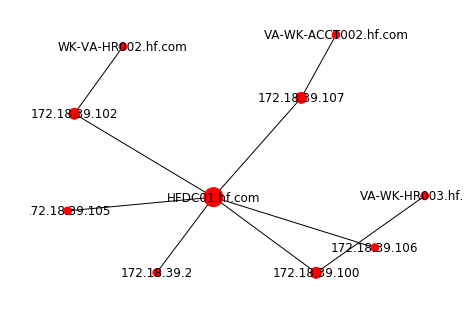

In [24]:
plt.show()